# Image Classification With Tensorflow
In this lesson we will build a *Convolutional Neural Network* (CNN) model to detect whether a blood cells have infected malaria disease or not. The dataset use in this project is available on [Tensorflow Dataset](https://www.tensorflow.org/datasets/catalog/malaria), it contains 2 classes, parasitized or unparasitized so we build binary classification. First we import libraries that we need.


## Imports

In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
from google.colab import files
from IPython.display import Image, display
from keras.preprocessing import image

## **Download the dataset**

The Malaria dataset contains a total of 27,558 cell images with equal instances (classes) of *parasitized* and *uninfected* cells from the thin blood smear slide images of segmented cells.

Note, that not every images have the same *pixel height* and *pixel width*

1. *malaria*: This is the name of the dataset you want to load. In this case it's the "malaria" dataset. TensorFlow Datasets provides various datasets for machine learning and data analysis, and you can specify the name of the dataset you're interested in.

2. ```with_info=True```: This parameter is set to True to include information about the dataset along with the loaded dataset. The additional information typically includes details about the dataset such as its size, number of classes, a description, and other metadata.

3. ```as_supervised=True```: Setting this parameter to True indicates that you want the dataset to be loaded in a supervised manner. In a supervised dataset, each example has both input features and corresponding labels. If set to False, the dataset may be loaded in an unsupervised manner, depending on the dataset.

4. ```shuffle_files=True```: This parameter controls whether the dataset files should be shuffled. Shuffling the files is important during training to introduce randomness and avoid biases that might arise if the data is ordered in a specific way.

5. ```split=["train"]```: This parameter specifies which split of the dataset to load. Datasets are often divided into different splits, such as "train," "test," and "validation." In this case, it's loading the training split.

6. ```data_dir```: TensorFlow Datasets has a caching mechanism that can interfere with shuffling. If the dataset has been previously loaded with shuffling disabled and cached, subsequent loads might use the cached version. To ensure shuffling, you can try clearing the cache or setting data_dir=None to avoid using a cached version.

After loading the dataset using the tfds.load function, two variables are assigned:

* ```dataset```: This variable holds the loaded dataset. The actual data samples and
labels are accessible through this variable.

* ```dataset_info```: This variable holds information about the dataset, as mentioned earlier. You can access details about the dataset using this variable, such as the number of classes, the size of the dataset, and other metadata.

In [ ]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
    split=["train"],
    data_dir=None
    )

In [ ]:
dataset_info

## **Understanding the Data**
1. **Pixel Values and Components**:

  * *Pixel Range*: In images, pixel values typically range from 0 to 255. Each pixel can be considered as a tiny element of the image.

  * *Color Components (Channels)*: For each pixel, there are three color components: Red, Green, and Blue (RGB). These components determine the color of the pixel in the image.

 \
2. **Normalization and Real Pixel Values**:

  * *Normalized Value*: The pixel values can be either normalized or unnormalized. Normalization involves dividing the pixel value by $255$. This brings the pixel value to a range between 0 and 1.

  * *Real Pixel Value*: To obtain the original (real) pixel value from a normalized value, you can multiply the normalized value by 255. The formula is:

  $$Real Value=Normalized Value×255$$

  * *Example*: If the normalized value is $0.5176$, the real pixel value is obtained by

  $$0.5176 \times 255 = 132$$

3. **Image Data Representation**:

  * *Tensor Dimensions*: Images can be represented as tensors with dimensions for Height, Width, and Channels.\
  For example, a tensor with shape (151, 115, 3) means:\
  Height = 151\
  Width = 115\
  Channels = 3 (Red, Green, Blue)

Example output:

```
(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0]

```
4. **Grayscale Format**:

  * *Grayscale Images*: In grayscale images, there is only one channel, and the image can be represented as a 2D tensor. Pixel values in grayscale images range from black (0) to white (255).

  * *Normalization in Grayscale*: If normalized, black corresponds to 0, and white corresponds to 1 in a grayscale image.


In [ ]:
# for data in dataset[0].take(1):
#   print(data)

## **Split the dataset**

This dataset already came with ["train"] split only. In order for us to create the *train, validation,* and *test* sets, we're going to use the *take* method and the *skip* method.

``` .take(n) ``` method is used to create a new dataset that contains only the first  ``` n ``` elements from the original dataset.

``` .skip(n) ``` method is used to create a new dataset that skips the first *n* elements from the original dataset.

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

**Define the dataset ratio**

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [ ]:
# dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(
#     list(train_dataset.take(1).as_numpy_iterator()),"\n",
#     list(val_dataset.take(1).as_numpy_iterator()),"\n",
#     list(test_dataset.take(1).as_numpy_iterator()),"\n",
#     )

**Dataset Visualization**

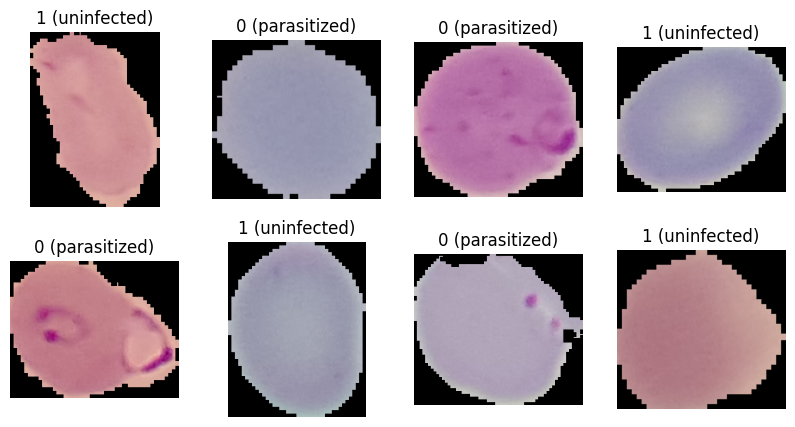

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, (image, label) in enumerate(val_dataset.take(8)):
    ax = axes[i // 4, i % 4]

    ax.imshow(image)

    class_number = label.numpy()
    class_string = dataset_info.features["label"].int2str(class_number)

    ax.set_title(f"{class_number} ({class_string})")

    ax.axis("off")

plt.show()

## **Data Processing**

Our data processing unit from now will be made of 2 parts:

1. **Resizing Operation**:

    ``` tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) ```
    
    This operation resizes the input image to the fixed size defined by IMG_SIZE (224 x 224 pixels).

2. **Rescaling Operation**:

    / 255.0: This operation divides the pixel values of the resized image by 255.0.
    The formula for rescaling can be expressed as $$X = \frac{X}{255.0}$$, where $X$ represents the pixel values of the resized image.

In summary, the mathematical formulas are as follows:

* Resizing Formula:
    ```
    resized_image=tf.image.resize(image,(IMG_SIZE,IMG_SIZE))resized_image=tf.image.resize(image,(IMG_SIZE,IMG_SIZE))

    ```
 * Rescaling Formula: 
    $$\text{rescaled image} = \frac{\text{resized image}}{255.0}$$

In [ ]:
IMG_SIZE = 224 # new fixed shape for all images 224 x 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, label

**Normalized the Training Image**

1. Objective:\
 Normalize input images to ensure that all data falls within a given range.

2. Normalization Formula:\
  The formula used is $X = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$
  In the context of image data, where pixel values range from 0 to 255, it simplifies to $X = 255.0 \cdot X$ .

3. Explanation of Formula:\
  * $X−0$ (Numerator): Subtracting $0$, as the minimum pixel value is assumed to be 0.
        
  * $X_{\text{max}} - X_{\text{min}}$​ (Denominator): In the case of image data, $X_{\text{max}}$ is 255 and $X_{\text{min}}$​ is 0.\
  The simplified form $X = \frac{X}{255.0}$ is used for normalization.

4. Choice between Standardization and Normalization:\
  decision depends on the characteristics of the data.

  * Standardization $$X = \frac{X - \text{mean}}{\text{standard deviation}}$$ Suitable when most pixel values revolve around a particular mean.
  
  * Normalization $$(X = \frac{X}{255.0})$$
  Suitable when pixel values are mostly different from one another.

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
for batch in train_dataset.take(1):
    images, labels = batch
    print(images.shape, labels.shape)

(224, 224, 3) ()


now the *shape* must be shape=(224, 224, 3).\
height = 224\
width = 224\
channels = 3 (RGB)

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(
    buffer_size=8,
    reshuffle_each_iteration=True
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(
    buffer_size=8,
    reshuffle_each_iteration=True
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## **Modelling**

To better understand the CNN layer **hyperparameters** (*input size, padding, kernel size, stride*) you can visit [CNN Explaner](https://poloclub.github.io/cnn-explainer/), [Setosa image-kernels](https://setosa.io/ev/image-kernels/).

**CNN Layer Hyperparameters**:

* *Input Size $(X_{\text{in}})$*: This represents the size of the input feature map or image that is passed to the convolutional layer. It is often expressed in terms of width and height.

* *Padding $(P)$*: Padding is the number of pixels added to the input feature map around its border. Padding helps to preserve spatial information during convolution and is often used to avoid the reduction in feature map size.

* *Kernel Size (F)*: The kernel (or filter) is a small window that slides over the input feature map during convolution. The kernel size refers to the dimensions of this window and is typically a square matrix.

* *$stride$*: Stride is the step size at which the kernel moves horizontally or vertically during the convolution operation. It determines how much the window shifts after each operation.

Formula for Calculating Output Size:

The formula provided is used to calculate the output size (Xout) of a convolutional layer:

\
$
Xout​=Xin​−F+2P/stride+1
$

or

$
X_{\text{out}} = \frac{X_{\text{in}} - F + 2P}{\text{stride}} + 1
$

\
$X_{\text{out}}$: Output size of the feature map after convolution.

$X_{\text{in}}$: Input size of the feature map.

$F$: Kernel size (filter size).

$P$: Padding.

$stride$: The step size at which the kernel moves.


In [ ]:
model = Sequential([
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])
model.summary()

model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

## Error Sanction

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
689/689 [==============================] - 44s 64ms/step - loss: 0.1143 - accuracy: 0.9614 - val_loss: 0.2203 - val_accuracy: 0.9325
Epoch 2/10
689/689 [==============================] - 42s 61ms/step - loss: 0.1181 - accuracy: 0.9605 - val_loss: 0.1654 - val_accuracy: 0.9412
Epoch 3/10
689/689 [==============================] - 51s 73ms/step - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.2472 - val_accuracy: 0.9016
Epoch 4/10
689/689 [==============================] - 42s 61ms/step - loss: 0.0937 - accuracy: 0.9677 - val_loss: 0.8986 - val_accuracy: 0.6142
Epoch 5/10
689/689 [==============================] - 44s 64ms/step - loss: 0.0853 - accuracy: 0.9714 - val_loss: 0.2107 - val_accuracy: 0.9336
Epoch 6/10
689/689 [==============================] - 41s 60ms/step - loss: 0.1070 - accuracy: 0.9615 - val_loss: 0.3619 - val_accuracy: 0.9281
Epoch 7/10
689/689 [==============================] - 42s 61ms/step - loss: 0.0827 - accuracy: 0.9709 - val_loss: 0.3010 - val_accuracy:

In [ ]:
history.history

{'loss': [0.11425739526748657,
  0.11805792897939682,
  0.10339950025081635,
  0.0937323346734047,
  0.08528726547956467,
  0.10700078308582306,
  0.08271307498216629,
  0.07504131644964218,
  0.07472830265760422,
  0.0658942312002182],
 'accuracy': [0.9614442586898804,
  0.9604917168617249,
  0.9656173586845398,
  0.967658519744873,
  0.9714233875274658,
  0.9615349769592285,
  0.970879077911377,
  0.9734645485877991,
  0.9736913442611694,
  0.9774108529090881],
 'val_loss': [0.22032371163368225,
  0.1654340922832489,
  0.2472161501646042,
  0.8986362814903259,
  0.2107488363981247,
  0.3619367480278015,
  0.3010255992412567,
  0.22336164116859436,
  0.2138165384531021,
  0.31107547879219055],
 'val_accuracy': [0.9324864149093628,
  0.9411978125572205,
  0.9016333818435669,
  0.6141560673713684,
  0.9335753321647644,
  0.9281306862831116,
  0.8929219841957092,
  0.9339382648468018,
  0.9263157844543457,
  0.9161524772644043]}

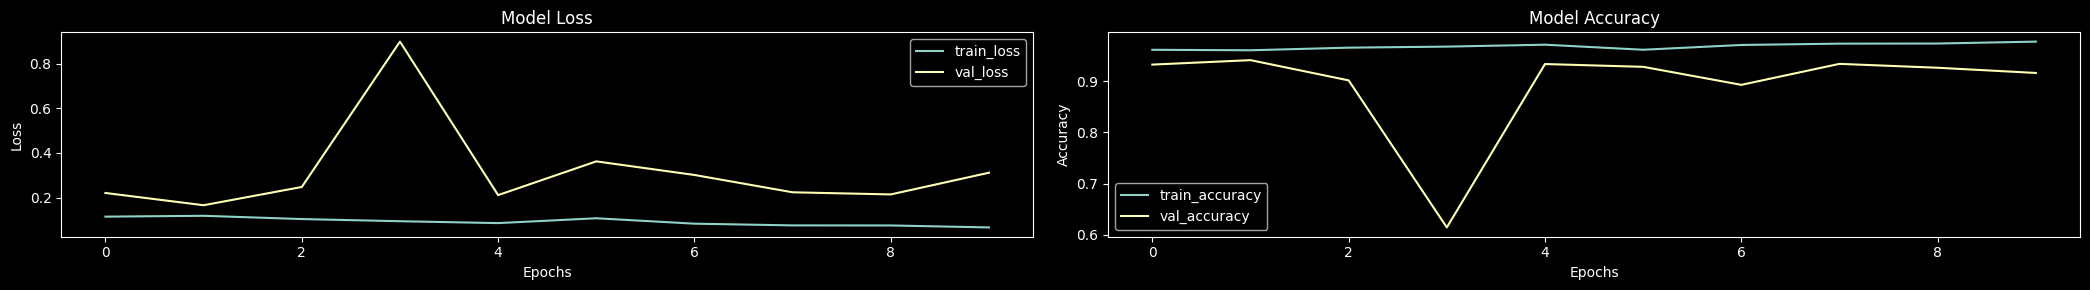

In [78]:
style.use("dark_background")
plt.figure(figsize=(21, 3)) # 21 = width, 3 = height
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train_loss", "val_loss"])

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train_accuracy", "val_accuracy"])

plt.tight_layout()
plt.show()

## Model Evaluation and Testing

make the ``` test_dataset ``` to have the same shape like ``` training_dataset ``` and ``` val_dataset ```

In [79]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**Evaluate the Model with test_dataset**

In [80]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 20s 3ms/step - loss: 0.3058 - accuracy: 0.9075


[0.30582261085510254, 0.907508134841919]

**Model Prediction**

Saving istockphoto-1577007873-612x612.jpg to istockphoto-1577007873-612x612.jpg
1/1 [==============================] - 0s 19ms/step


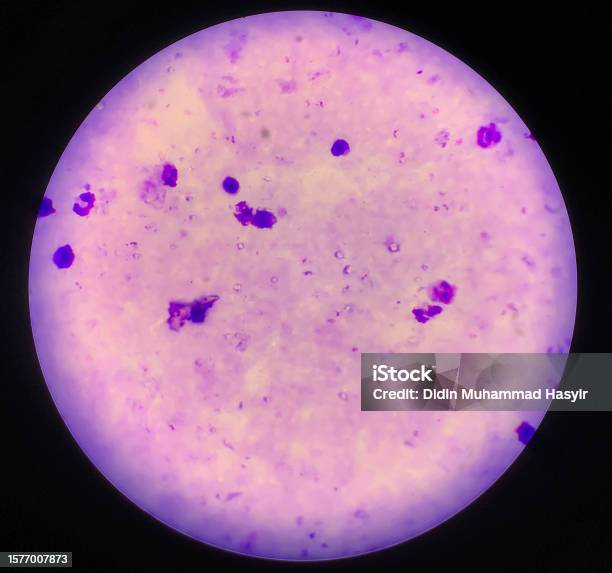

Predicted Class: parasitized


In [85]:
class_mapping = {0: 'parasitized', 1: 'uninfected'}
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)

    predicted_class = class_mapping[predicted_class_index]

    return predicted_class

uploaded = files.upload()

img_path = list(uploaded.keys())[0]

predicted_class = predict_image(img_path)

display(Image(img_path))
print("Predicted Class:", predicted_class)

You can also use the ```test_dataset```

In [86]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.9403886